First few rows of the data:
       director_name  num_critic_for_reviews  director_facebook_likes  \
0      James Cameron                   723.0                      0.0   
1     Gore Verbinski                   302.0                    563.0   
2         Sam Mendes                   602.0                      0.0   
3  Christopher Nolan                   813.0                  22000.0   
4        Doug Walker                     NaN                    131.0   

   actor_3_facebook_likes      actor_2_name  actor_1_facebook_likes  \
0                   855.0  Joel David Moore                  1000.0   
1                  1000.0     Orlando Bloom                 40000.0   
2                   161.0      Rory Kinnear                 11000.0   
3                 23000.0    Christian Bale                 27000.0   
4                     NaN        Rob Walker                   131.0   

                            genres     actor_1_name  \
0  Action|Adventure|Fantasy|Sci-Fi      CCH Pounder

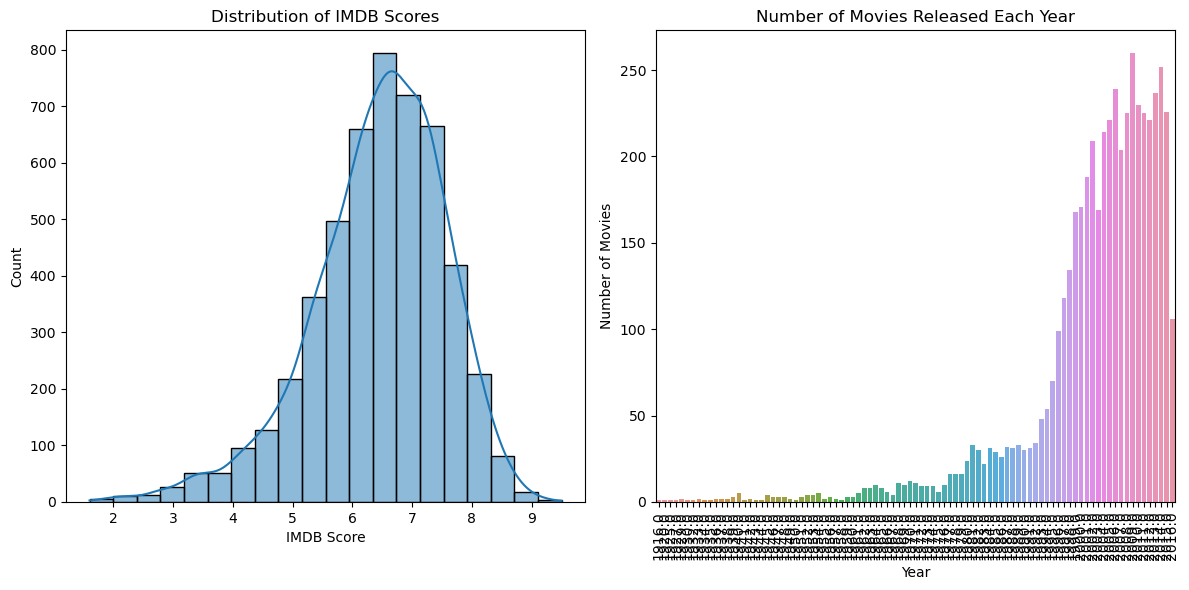

Random Forest Accuracy: 1.0


In [5]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data_from_csv(filepath):
    data = pd.read_csv(filepath)
    # Normalize movie titles in the dataset
    data['movie_title'] = data['movie_title'].str.lower().str.strip()
    return data

def save_data_to_sql(data, db_name='movie_database.sqlite', table_name='movies'):
    conn = sqlite3.connect(db_name)
    data.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()

def load_data_from_sql(db_name='movie_database.sqlite', table_name='movies'):
    conn = sqlite3.connect(db_name)
    query = f"SELECT * FROM {table_name}"
    data = pd.read_sql_query(query, conn)
    conn.close()
    return data

def clean_and_prepare_data(data):
    data.dropna(inplace=True)
    data['title_year'] = data['title_year'].fillna(data['title_year'].mean()).astype(int)
    data = pd.get_dummies(data, columns=['director_name', 'actor_1_name'])
    features = data.select_dtypes(include=[np.number])
    labels = data['imdb_score'] > data['imdb_score'].mean()
    return train_test_split(features, labels, test_size=0.2, random_state=42)

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return accuracy_score(y_test, predictions)

data = load_data_from_csv('/Users/xueyilu/Desktop/Project-4/cleaned_data.csv')
save_data_to_sql(data)
data = load_data_from_sql()

# Display the first few rows of the DataFrame
print("First few rows of the data:")
print(data.head())


# Plotting
def plot_data(data):
    plt.figure(figsize=(12, 6))

    # Histogram of IMDB Scores
    plt.subplot(1, 2, 1)
    sns.histplot(data['imdb_score'], bins=20, kde=True)
    plt.title('Distribution of IMDB Scores')
    plt.xlabel('IMDB Score')
    plt.ylabel('Count')

    # Bar Chart of Movies by Year
    plt.subplot(1, 2, 2)
    year_counts = data['title_year'].value_counts().sort_index()
    sns.barplot(x=year_counts.index, y=year_counts.values)
    plt.title('Number of Movies Released Each Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_data(data)



X_train, X_test, y_train, y_test = clean_and_prepare_data(data)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_accuracy = train_and_evaluate_model(X_train, y_train, X_test, y_test, rf_model)
print("Random Forest Accuracy:", rf_accuracy)






In [7]:
def predict_movie_success(title, model, data, all_columns):
    try:
        # Search for the movie
        movie_data = data[data['movie_title'].str.contains(title, case=False)]
        if movie_data.empty:
            return "Movie not found."

        # Prepare features for the prediction
        movie_data_prepared = movie_data.fillna({'num_critic_for_reviews': data['num_critic_for_reviews'].mean()})
        movie_data_prepared = pd.get_dummies(movie_data_prepared, columns=['director_name', 'actor_1_name'])

        # Prepare a dictionary to add missing columns with zeros
        missing_cols = {col: 0 for col in set(all_columns) - set(movie_data_prepared.columns)}
        # Add all missing columns at once
        movie_data_prepared = pd.concat([movie_data_prepared, pd.DataFrame(missing_cols, index=movie_data_prepared.index)], axis=1)

        # Ensure all columns are in the correct order
        movie_data_prepared = movie_data_prepared[all_columns]

        # Extract features and reshape for prediction
        features = movie_data_prepared.select_dtypes(include=[np.number]).iloc[0].values.reshape(1, -1)
        prediction = model.predict(features)
        success_status = "Likely to be successful" if prediction else "Likely not successful"

        # Create a detailed response
        details = movie_data.iloc[0] 
        response = f"Title: {details['movie_title'].strip()} - {success_status}\n"
        response += f"Director: {details.get('director_name', 'N/A')}\n"
        response += f"Main Actor: {details.get('actor_1_name', 'N/A')}\n"
        response += f"IMDB Score: {details.get('imdb_score', 'N/A')}\n"
        response += f"Number of Critic Reviews: {details.get('num_critic_for_reviews', 'N/A')}"

        return response
    except Exception as e:
        return f"Error in prediction: {str(e)}"

def user_interface():
    title = input("Enter the title of the movie: ")
    result = predict_movie_success(title, rf_model, data, X_train.columns)  
    print(result)

# To start the user interface:
user_interface()


Enter the title of the movie:  spectre


Title: spectre - Likely to be successful
Director: Sam Mendes
Main Actor: Christoph Waltz
IMDB Score: 6.8
Number of Critic Reviews: 602.0


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
